<a href="https://colab.research.google.com/github/Lautz97/Binary-Functions-Classification-with-Machine-Learning/blob/main/ML_hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

Binary Functions Classification

Dataset 1: with duplicates
https://drive.google.com/file/d/1vKT9OzJwM6gKACyElzECW49X5nFeVxad

Dataset 2: without duplicates
https://drive.google.com/file/d/1olYSZIqHbKQQh__l222cwDj33n3h-zAk


# Global imports.

In [108]:
!pip install ipython-autotime

%load_ext autotime

from google.colab import files
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx import json_graph

import re

from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

from sklearn.naive_bayes import *
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression


print("importing libraries.......done")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
importing libraries.......done
time: 2.59 s


In [109]:
#@title Variable settings { run: "auto" }
#@markdown To customize:

#@markdown ###   Paths

# True or False
use_drive=True #@param {type:"boolean"}

# in case of retrieving data from g_drive the drive will be mounted
# specify where here
drive_mount_path = "/content/drive" #@param {type:"string"} 
  
# now specify the directory of dataset and blindset
# in this directory will be also stored a 
# json file with the blindtest predictions
datadir = "/content/drive/My Drive/MLHW1" #@param {type:"string"}

# or you can simply upload file by file by setting use_drive to False

#@markdown ### File names

# specify now file names
dataset = "dataset.json" #@param {type:"string"}
blindset = "blindtest.json" #@param {type:"string"}
prediction = "predictions.json" #@param {type:"string"}

#@markdown ### Vectorizer

# specify here what vectorizer to use
# "hash", "count" or "tfid"
vectorizer_type = "hash" #@param ["hash", "count", "tfid"]{type:"string"}

#@markdown ### Model

# "logreg", "bernoulli" or "multinomial"
model_type = "logreg" #@param ["logreg", "bernoulli", "multinomial"]{type:"string"}

print("done!")

done!
time: 8.51 ms


# Dataset Selection

Upload dataset from file system, or take it from gdrive.

In [110]:
if(use_drive):
  from google.colab import drive
  drive.mount(drive_mount_path, True)
  dataset = datadir + "/" + dataset
else:
  uploaded = files.upload()
  datadir = ""


print(dataset)

Mounted at /content/drive
/content/drive/My Drive/MLHW1/dataset.json
time: 1.12 s


# Read Dataset
Using pandas to handle the data reading and presenting them.


In [111]:
data = pd.read_json(dataset, lines=True)

print(data.shape)
data.head()

(6073, 4)


,id,semantic,lista_asm,cfg
0,828,string,"['jmp qword ptr [rip + 0x220882]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
1,11786,math,"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...","{'directed': True, 'graph': [], 'nodes': [{'id..."
2,12621,encryption,"['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...","{'directed': True, 'graph': [], 'nodes': [{'id..."
3,11166,math,"['mov qword ptr [rsp - 0x10], rbx', 'mov qword...","{'directed': True, 'graph': [], 'nodes': [{'id..."
4,10432,sort,"['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."


time: 1.48 s


# Understanding the dataset

Extracting the population's proportions of the dataset and the length of each lista_asm that can be a valuable parameter, as long as extra informations about the control flow graph.

To dig into the cfg is used the "networkx" library.

,id,semantic,lista_asm,cfg,asm_len,n_nodes,n_edges,g_complexity
0,828,string,"['jmp qword ptr [rip + 0x220882]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id...",2380,23,30,30
1,11786,math,"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...","{'directed': True, 'graph': [], 'nodes': [{'id...",819,15,20,20
2,12621,encryption,"['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...","{'directed': True, 'graph': [], 'nodes': [{'id...",10231,18,33,24
3,11166,math,"['mov qword ptr [rsp - 0x10], rbx', 'mov qword...","{'directed': True, 'graph': [], 'nodes': [{'id...",272,2,1,1
4,10432,sort,"['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id...",1597,22,35,29


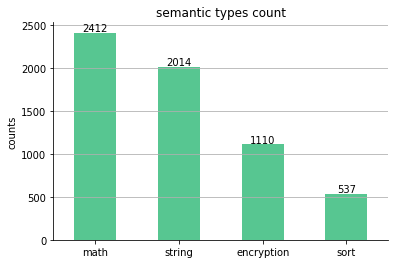

time: 3.03 s


In [112]:
fig = plt.figure()
ax = fig.add_subplot(111)

data['semantic'].value_counts().plot(kind='bar', color = '#1fb46c', alpha=0.75, grid=True)

plt.ylabel('counts')
plt.title('semantic types count')
plt.xticks(rotation='horizontal')
ax.xaxis.grid(which="major")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()+50), ha='center', va='center')

# add a column for the total length of the asm list
data['asm_len'] = data.lista_asm.apply(len)

def asm_stringlist2vector(asm):
  v_asm = eval(asm)
  return v_asm

def process_networkx(itm):
  return json_graph.adjacency_graph(itm) 

def complexity(G):
    edges = len(G.edges())
    nodes = len(G.nodes())
    parts = nx.components.number_strongly_connected_components(G)
    return edges - nodes + parts

data['cfg_nx'] = data.cfg.apply(process_networkx)
# print(nx.info(data['cfg_nx'][0]))

data['n_nodes'] = data.cfg_nx.apply(lambda g: len(g.nodes()))
data['n_edges'] = data.cfg_nx.apply(lambda g: len(g.edges()))
# from https://gist.github.com/ivg/e035b84edcaab70526c633cb3749b0e9
data['g_complexity'] = data.cfg_nx.apply(complexity)

data = data.drop(columns=['cfg_nx'])

# view new data set
# print(data.shape)
data.head()

# Bag of word features extraction.


In [113]:
if vectorizer_type == "hash":
  # many features would lower the accuracy
  vectorizer = HashingVectorizer(n_features=10000,norm=None,alternate_sign=False)
elif vectorizer_type == "count":
  vectorizer = CountVectorizer(binary=True) 
elif vectorizer_type == "tfid":
  vectorizer = TfidfVectorizer()

# tokenization and vocaboulary building
v = vectorizer.fit(data["lista_asm"])

#cool visualization if vectorizer_type == count
if(vectorizer_type=="tfid" or vectorizer_type=="count"):
  # print the count of different words contained in asm list
  print ('number of features: {}'.format(len(v.vocabulary_)))
  # visualize the result
  wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(v.vocabulary_))
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.show()

# sparse matrix encoding, resulting in one vector of word counts for each document.
asm_list_vectorized = v.transform(data['lista_asm'])
print("transformed feature vector's shape = ", asm_list_vectorized.get_shape())

transformed feature vector's shape =  (6073, 10000)
time: 2.62 s


# Data splitting


In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(asm_list_vectorized.toarray(), data['semantic'], test_size=0.2, random_state=15)

print("Training set length: %d \nTesting set length: %d" %(X_train.shape[0],X_test.shape[0]))

Training set length: 4858 
Testing set length: 1215
time: 254 ms


# Training model!


In [115]:
if model_type == "bernoulli":
  model = BernoulliNB().fit(X_train, Y_train)
  print('Bernoulli Model created')
elif model_type == "multinomial":
  model = MultinomialNB().fit(X_train, Y_train)
  print('Multinomial Model created')
elif model_type == "logreg":
  scikit_log_reg = LogisticRegression(solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
  model=scikit_log_reg.fit(X_train,Y_train)
  print('Logistic Regression Model created')

Logistic Regression Model created
time: 4.12 s


# Testing the trained model



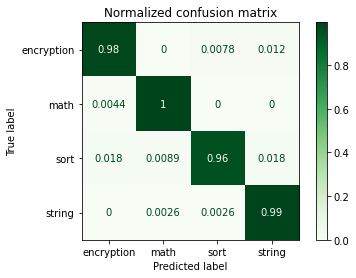

              precision    recall  f1-score   support

  encryption       0.98      0.98      0.98       256
        math       1.00      1.00      1.00       456
        sort       0.97      0.96      0.96       112
      string       0.99      0.99      0.99       391

    accuracy                           0.99      1215
   macro avg       0.98      0.98      0.98      1215
weighted avg       0.99      0.99      0.99      1215

time: 549 ms


In [116]:
Y_pred = model.predict(X_test)

from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()



# print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))


# Predicting what's in the blind set



In [118]:
if(use_drive):
  blinddir = datadir
  blindset_p = blinddir + "/" + blindset
else:
  uploaded = files.upload()
  blinddir = ""

print("blindset file found in: ", blindset_p)

blind = pd.read_json(blindset_p, lines=True)

print("blind test shape = ", blind.shape)

# already done before tokenization and vocaboulary building
# this action would cancel the vocabulary
# vb = vectorizer.fit(blind["lista_asm"])

# sparse matrix encoding, resulting in one vector of word counts for each document.
blind_list_vectorized = v.transform(blind['lista_asm'])
print("transformed feature vector's shape = ", blind_list_vectorized.get_shape())


Y_pred = model.predict(blind_list_vectorized.toarray())
# print(confusion_matrix(Y_test, Y_pred))
# print(classification_report(Y_test, Y_pred))

print("prediction model used: " + model_type)

pred_path = datadir + "/" + prediction
Y_pred_list = Y_pred.tolist()
if(use_drive):
  with open(pred_path, "w") as outfile:
      json.dump(Y_pred_list, outfile)
  print("prediction of blindset's functions semantic can be found in: " + datadir + "/" + prediction)
else:
  question = "do you want me to print here the result of the prediction? will be a " + str(len(Y_pred_list)) + " item list [y/n]  "
  answ = input(question)
  if(answ=="n"):
    answ = input("do you want to print the list on a json file? [y/n]  ")
    if(answ=="y"):
      path = input("specify the local path: ")
      with open(path + "/" + prediction, "w") as outfile:
        json.dump(Y_pred_list, outfile)
      print("prediction of blindset's functions semantic can be found in: " + path + "/" + prediction)
  else:
    print("Printing list of predisctions: \n")
    print(Y_pred_list)
print("done!")

blindset file found in:  /content/drive/My Drive/MLHW1/blindtest.json
blind test shape =  (757, 3)
transformed feature vector's shape =  (757, 10000)
prediction model used: logreg
prediction of blindset's functions semantic can be found in: /content/drive/My Drive/MLHW1/predictions.json
done!
time: 391 ms
